Nume: Horjea Cosmin-Marian 

Grupa: 343

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
from typing import Iterator, List, Callable, Tuple
from matplotlib import rc, cm
rc('animation', html='jshtml')

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
%matplotlib notebook

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# 0
path='gdrive/MyDrive/pmi-data.csv'
data= pd.read_csv(path)
print(len(data))
data.head()

3566


,Unnamed: 0,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,9046,2,67.0,0,1,1,4,0,228.69,36.6,1,1
1,1,51676,1,61.0,0,0,1,3,1,202.21,29.1,2,1
2,2,31112,2,80.0,0,1,1,4,1,105.92,32.5,2,1
3,3,60182,1,49.0,0,0,1,4,0,171.23,34.4,0,1
4,4,1665,1,79.0,1,0,1,3,1,174.12,24.0,2,1


In [4]:
y = data.stroke
X = data

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.2,train_size = 0.8, random_state = 42, shuffle = True)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
# Doing a Validation set instead of just train and test sets its generally better 
# because it keeps us form fine tunig a model around a test set and eventually 
# performing poor in real world, this way we fine tune the model to get good
# accuracy on the validation set, and the final accuracy it's given by the test set,
# that the model never saw
# Shuffling the data assures us that we'll get both type of rows in our datasets (stroke,no stroke)
# because the first rows in the csv are all labeled with stroke while the next ones are labeled with no_stroke

(2852, 13)
(2852,)
(714, 13)
(714,)


In [5]:
# 2 The datasets and data loader
from torch.utils.data import DataLoader,Dataset
import torch

In [6]:
class BMIDataset(Dataset):
  def __init__(self,data):
    self.data = data
  def __len__(self):
    return len(self.data)
  def __getitem__(self,idx):
    data_tensor = torch.tensor(self.data.iloc[idx,2:-1]).type(torch.FloatTensor)
    label_tensor = torch.tensor([self.data.iloc[idx,-1]]).type(torch.FloatTensor)
    return data_tensor,label_tensor

BATCH_SIZE=32
train_dataset = BMIDataset(X_train)
val_dataset = BMIDataset(X_val)


train_dataloader = DataLoader(
    dataset=train_dataset,
    shuffle= True,
    batch_size = BATCH_SIZE
)

val_dataloader = DataLoader(
    dataset = val_dataset,
    shuffle=True,
    batch_size = BATCH_SIZE
)


In [7]:
# 3
class StrokeClassifier(nn.Module):
  def __init__(self,
               input_size:int,
               hidden_size_1:int,
               hidden_size_2:int,
               activation_fn:Callable):
    super().__init__()
    self.input_size = input_size
    self.hidden_size_1 = hidden_size_1
    self.hidden_size_2 = hidden_size_2
    self.layer_1 = nn.Linear(input_size,hidden_size_1)
    self.layer_2 = nn.Linear(hidden_size_1,hidden_size_2)
    self.output_layer = nn.Linear(hidden_size_2,1)
    self.activation_fn = activation_fn

  def forward(self,x):
    h1 = self.activation_fn(self.layer_1(x))
    h2 = self.activation_fn(self.layer_2(h1))
    out = self.output_layer(h2)

    return out

model = StrokeClassifier(10,10,10,nn.ReLU())
num_params = 0
print("Model's parameters: ")
for param in model. parameters():
  print(param)


Model's parameters: 
Parameter containing:
tensor([[ 0.2081,  0.1968,  0.1752,  0.2982,  0.0074,  0.0767, -0.1193,  0.1596,
          0.0639, -0.2251],
        [-0.2543,  0.1716,  0.2566, -0.0269, -0.0569, -0.2646, -0.2752, -0.0561,
         -0.0969, -0.1372],
        [-0.1493, -0.1493, -0.0407, -0.1188, -0.2509,  0.3020,  0.1494,  0.0407,
          0.1511,  0.2589],
        [ 0.1681,  0.0085, -0.2506, -0.2945,  0.0262,  0.2929,  0.1036, -0.1009,
          0.1253, -0.1010],
        [ 0.1529,  0.1962, -0.1710, -0.1859, -0.0265, -0.2624, -0.1993, -0.0997,
         -0.0876,  0.2889],
        [ 0.1187, -0.1323, -0.1348,  0.0877, -0.2213,  0.2410, -0.2461,  0.1740,
          0.2139, -0.1666],
        [ 0.1570, -0.2573, -0.0951,  0.1461, -0.1094,  0.0416, -0.2699, -0.2679,
          0.1477, -0.1782],
        [ 0.0469, -0.0520,  0.1721,  0.0862,  0.1972, -0.1023,  0.0072,  0.0214,
          0.1241, -0.2602],
        [-0.1936,  0.2218, -0.1416, -0.1830,  0.0600,  0.1875,  0.3032,  0.2867,
    

In [8]:
loss_criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
def compute_accuracy(predictions: List[int], labels:List[int]) -> float:
    num_correct = len([(p,l) for (p,l) in zip(predictions,labels) if p==l])
    epoch_accuracy = num_correct/len(labels)
    
    return epoch_accuracy

In [10]:
def train_epoch(model, train_dataloader, loss_crt, optimizer,device):
    model.train()
    epoch_loss = 0.0
    num_batches = len(train_dataloader)
    predictions = []
    labels = []
    for idx, batch in enumerate(train_dataloader):
        batch_data, batch_labels = batch

        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)
        
        output = model(batch_data)        

        batch_predictions = torch.round(torch.sigmoid(output)).squeeze()

        predictions += batch_predictions.tolist()
        labels += batch_labels.squeeze().tolist()

        loss = loss_crt(output.squeeze(), batch_labels.squeeze())
        loss_scalar = loss.item()

        loss.backward()

        optimizer.step()
        model.zero_grad()
        

        epoch_loss += loss_scalar

    epoch_loss = epoch_loss/num_batches

    return epoch_loss, predictions, labels

def eval_epoch(model, val_dataloader, loss_crt,device):
    model.eval()
    epoch_loss = 0.0
    num_batches = len(val_dataloader)
    predictions = []
    labels = []
    with torch.no_grad():
        for idx, batch in enumerate(val_dataloader):
            batch_data, batch_labels = batch

            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            
            output = model(batch_data)

            batch_predictions = torch.round(torch.sigmoid(output)).squeeze()

            predictions += batch_predictions.tolist()
            labels += batch_labels.squeeze().tolist()

            loss = loss_crt(output.squeeze(), batch_labels.squeeze())
            loss_scalar = loss.item()

            epoch_loss += loss_scalar

    epoch_loss = epoch_loss/num_batches

    return epoch_loss, predictions, labels

In [11]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

hyperparams = {
    'num_epochs': 20,
}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch_idx in range(hyperparams['num_epochs']):
    train_epoch_loss, train_predictions, train_labels = train_epoch(
        model, 
        train_dataloader, 
        loss_criterion, 
        optimizer,
        device)
    val_epoch_loss, val_predictions, val_labels = eval_epoch(
        model,
        val_dataloader,
        loss_criterion,
        device
    )
    train_acc = compute_accuracy(train_predictions, train_labels)
    val_acc = compute_accuracy(val_predictions, val_labels)
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print("epoch %d, train loss=%f, train acc=%f, val loss=%f, val acc=%f" % (
        epoch_idx, 
        train_epoch_loss,
        train_acc,
        val_epoch_loss,
        val_acc
    ))


epoch 0, train loss=0.365776, train acc=0.859397, val loss=0.289126, val acc=0.931373
epoch 1, train loss=0.242138, train acc=0.946353, val loss=0.272813, val acc=0.931373
epoch 2, train loss=0.218477, train acc=0.946353, val loss=0.232936, val acc=0.931373
epoch 3, train loss=0.203627, train acc=0.946353, val loss=0.243405, val acc=0.931373
epoch 4, train loss=0.198190, train acc=0.946353, val loss=0.228101, val acc=0.931373
epoch 5, train loss=0.196595, train acc=0.946353, val loss=0.225329, val acc=0.931373
epoch 6, train loss=0.194527, train acc=0.946353, val loss=0.225181, val acc=0.931373
epoch 7, train loss=0.196224, train acc=0.946353, val loss=0.227444, val acc=0.931373
epoch 8, train loss=0.195956, train acc=0.946353, val loss=0.232675, val acc=0.931373
epoch 9, train loss=0.191896, train acc=0.946353, val loss=0.237275, val acc=0.931373
epoch 10, train loss=0.191374, train acc=0.946353, val loss=0.241083, val acc=0.931373
epoch 11, train loss=0.195249, train acc=0.946353, va

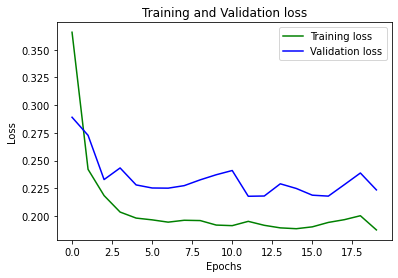

In [12]:
%matplotlib inline
NUM_EPOCHS=hyperparams['num_epochs']
plt.plot(range(0,len(train_losses)), train_losses, 'g', label='Training loss')
plt.plot(range(0,len(train_losses)), val_losses, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

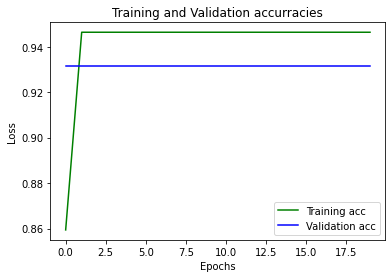

In [13]:
NUM_EPOCHS=hyperparams['num_epochs']
plt.plot(range(0,len(train_accuracies)), train_accuracies, 'g', label='Training acc')
plt.plot(range(0,len(val_accuracies)), val_accuracies, 'b', label='Validation acc')
plt.title('Training and Validation accurracies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
def compute_confusion_matrix(predictions: List[int], labels:List[int]) -> Tuple[int]:
    correct_stroke = 0
    correct_no_stroke = 0
    wrong_stroke = 0
    wrong_no_stroke = 0
    for (p,l) in zip(predictions, labels):
        if p == 0 and l == 0:
            correct_stroke += 1
        elif p == 0 and l == 1:
            wrong_stroke += 1
        elif p == 1 and l == 1:
            correct_no_stroke += 1
        else:
            wrong_no_stroke += 1

    return (correct_stroke, wrong_stroke, correct_no_stroke, wrong_no_stroke)

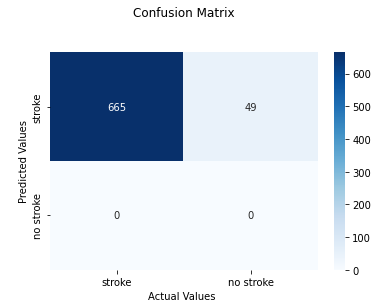

In [15]:
correct_stroke, wrong_stroke, correct_no_stroke, wrong_no_stroke = compute_confusion_matrix(
    val_predictions,
    val_labels
)
cf_matrix = [
    [correct_stroke, wrong_stroke],
    [correct_no_stroke, wrong_no_stroke]
]
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Confusion Matrix\n\n');
ax.set_ylabel('\nPredicted Values')
ax.set_xlabel('Actual Values ');

ax.xaxis.set_ticklabels(['stroke','no stroke'])
ax.yaxis.set_ticklabels(['stroke','no stroke'])

plt.show()

In [16]:
pos_weight = torch.tensor([16]).to(device)
loss_criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# out dataset has only 203 positive samples, while it has around 3300 negative ones,
# we set the pos_weight argument with [16]

In [17]:
# we now run the epochs again with the param set for our loss function
from sklearn.metrics import precision_recall_fscore_support

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch_idx in range(hyperparams['num_epochs']):
    train_epoch_loss, train_predictions, train_labels = train_epoch(
        model, 
        train_dataloader, 
        loss_criterion, 
        optimizer,
        device)
    val_epoch_loss, val_predictions, val_labels = eval_epoch(
        model,
        val_dataloader,
        loss_criterion,
        device
    )
    train_acc = compute_accuracy(train_predictions, train_labels)
    val_acc = compute_accuracy(val_predictions, val_labels)
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print("epoch %d,\ntrain loss=%f, train acc=%f, val loss=%f, val acc=%f" % (
        epoch_idx, 
        train_epoch_loss,
        train_acc,
        val_epoch_loss,
        val_acc
    ))
    train_precision, train_recall, train_f1_score, _ =  precision_recall_fscore_support(train_labels,train_predictions,average='macro')
    val_precision, val_recall, val_f1_score, _ =  precision_recall_fscore_support(val_labels,val_predictions,average='macro')
    print("train_precision=%f, train_recall=%f, train_f1=%f,\nval_precision  =%f, val_recall  =%f, val_f1  =%f " % (
        train_precision, 
        train_recall, 
        train_f1_score,
        val_precision, 
        val_recall, 
        val_f1_score
    ))



epoch 0,
train loss=1.077039, train acc=0.641304, val loss=1.150502, val acc=0.593838
train_precision=0.547094, train_recall=0.721086, train_f1=0.482176,
val_precision  =0.550855, val_recall  =0.696885, val_f1  =0.471057 
epoch 1,
train loss=1.021563, train acc=0.632188, val loss=1.128459, val acc=0.669468
train_precision=0.544455, train_recall=0.710104, train_f1=0.475447,
val_precision  =0.560048, val_recall  =0.718582, val_f1  =0.516060 
epoch 2,
train loss=0.957060, train acc=0.705820, val loss=1.150861, val acc=0.756303
train_precision=0.559467, train_recall=0.758256, train_f1=0.523885,
val_precision  =0.571091, val_recall  =0.717938, val_f1  =0.564268 
epoch 3,
train loss=0.951454, train acc=0.685835, val loss=1.517168, val acc=0.858543
train_precision=0.555410, train_recall=0.747696, train_f1=0.510786,
val_precision  =0.577512, val_recall  =0.631042, val_f1  =0.592270 
epoch 4,
train loss=1.000704, train acc=0.691094, val loss=1.101343, val acc=0.665266
train_precision=0.555154, 

In [18]:
# Regression Task
# 1
# Regression helps us predict continous variables, like a price for a product, 
# not just classes, and during training our loss it's given by how far we are 
# from the expected number

In [19]:
# 2
y = data.bmi
X = data

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.2,train_size = 0.8, random_state = 42, shuffle = True)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(2852, 13)
(2852,)
(714, 13)
(714,)


In [20]:
class BMIDataset(Dataset):
  def __init__(self,data):
    self.data = data
  def __len__(self):
    return len(self.data)
  def __getitem__(self,idx):
    data_tensor = torch.tensor(self.data.iloc[idx,~self.data.columns.isin(['Unnamed: 0','id', 'bmi'])]).type(torch.FloatTensor)
    label_tensor = torch.tensor([self.data.iloc[idx,-3]]).type(torch.FloatTensor)
    return data_tensor,label_tensor

BATCH_SIZE=32
train_dataset = BMIDataset(X_train)
val_dataset = BMIDataset(X_val)

print(train_dataset[0])
print(train_dataset[1])
print(train_dataset[2])


train_dataloader = DataLoader(
    dataset=train_dataset,
    shuffle= True,
    batch_size = BATCH_SIZE
)

val_dataloader = DataLoader(
    dataset = val_dataset,
    shuffle=True,
    batch_size = BATCH_SIZE
)

(tensor([ 1.0000, 60.0000,  0.0000,  0.0000,  1.0000,  4.0000,  0.0000, 97.4300,
         0.0000,  1.0000]), tensor([26.4000]))
(tensor([ 1.0000, 50.0000,  0.0000,  0.0000,  1.0000,  4.0000,  1.0000, 68.4100,
         0.0000,  0.0000]), tensor([23.9000]))
(tensor([ 2.0000, 62.0000,  0.0000,  1.0000,  1.0000,  3.0000,  0.0000, 56.3100,
         1.0000,  0.0000]), tensor([24.3000]))


In [21]:
class BMIRegression(nn.Module):
  def __init__(self,
               input_size:int,
               hidden_size_1:int,
               hidden_size_2:int,
               activation_fn:Callable):
    super().__init__()
    self.input_size = input_size
    self.hidden_size_1 = hidden_size_1
    self.hidden_size_2 = hidden_size_2
    self.layer_1 = nn.Linear(input_size,hidden_size_1)
    self.layer_2 = nn.Linear(hidden_size_1,hidden_size_2)
    self.output_layer = nn.Linear(hidden_size_2,1)
    self.activation_fn = activation_fn

  def forward(self,x):
    h1 = self.activation_fn(self.layer_1(x))
    h2 = self.activation_fn(self.layer_2(h1))
    out = self.output_layer(h2)

    return out

model_reg = BMIRegression(10,50,50,nn.ReLU())
num_params = 0
print("Model's parameters: ")
for param in model_reg.parameters():
  print(param)


Model's parameters: 
Parameter containing:
tensor([[ 2.6770e-01,  8.7218e-02,  4.1006e-02, -2.8933e-01, -8.1523e-02,
         -2.9218e-01, -3.4632e-02,  1.1790e-01,  2.6855e-01,  1.1461e-01],
        [ 2.4624e-01, -1.2946e-01,  1.9953e-01,  2.0410e-01, -3.2131e-02,
         -1.4590e-01,  2.9709e-01,  4.6726e-02,  1.2114e-01, -9.6765e-02],
        [-1.7031e-01, -2.8814e-01, -2.4775e-01,  1.5655e-01,  8.6122e-02,
          2.4041e-02,  3.0438e-01, -1.1593e-01,  2.3548e-01, -4.5385e-02],
        [-2.7646e-01, -3.2432e-02,  1.1282e-01, -9.1578e-02, -1.6874e-01,
         -3.1611e-01,  2.9066e-01,  1.8306e-01,  2.9342e-01,  2.6324e-01],
        [ 3.9530e-02, -1.8213e-01, -5.6402e-02,  2.7425e-02, -2.1862e-01,
          1.3451e-01, -4.8869e-02,  1.8115e-01,  1.7060e-01, -8.3592e-02],
        [ 2.3447e-01, -4.0943e-02, -7.3127e-02,  2.4078e-01, -1.6995e-01,
          2.5066e-01, -1.0420e-01, -4.3432e-02,  1.2524e-01, -2.4586e-01],
        [ 4.8367e-02, -4.5520e-02, -1.0052e-01, -1.1729e-01, -1

In [22]:
loss_criterion = nn.L1Loss() # we use other loss function because binary cross entropy doesn't work anymore for a regression task
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [26]:
def train_epoch(model, train_dataloader, loss_crt, optimizer,device):
    model.train()
    epoch_loss = 0.0
    num_batches = len(train_dataloader)
    predictions = []
    labels = []
    for idx, batch in enumerate(train_dataloader):
        batch_data, batch_labels = batch

        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)
        
        output = model(batch_data)

        batch_predictions = output.squeeze()

        predictions += batch_predictions.tolist()
        labels += batch_labels.squeeze().tolist()

        loss = loss_crt(output.squeeze(), batch_labels.squeeze())
        loss_scalar = loss.item()

        loss.backward()

        optimizer.step()
        model.zero_grad()
        
        epoch_loss += loss_scalar

    epoch_loss = epoch_loss/num_batches

    return epoch_loss, predictions, labels

def eval_epoch(model, val_dataloader, loss_crt,device):
    model.eval()
    epoch_loss = 0.0
    num_batches = len(val_dataloader)
    predictions = []
    labels = []
    with torch.no_grad():
        for idx, batch in enumerate(val_dataloader):
            batch_data, batch_labels = batch

            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            
            output = model(batch_data)

            batch_predictions = output.squeeze()

            predictions += batch_predictions.tolist()
            labels += batch_labels.squeeze().tolist()

            loss = loss_crt(output.squeeze(), batch_labels.squeeze())
            loss_scalar = loss.item()

            epoch_loss += loss_scalar

    epoch_loss = epoch_loss/num_batches

    return epoch_loss, predictions, labels

In [27]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

hyperparams = {
    'num_epochs': 10,
}
model_reg.to(device)

for epoch_idx in range(hyperparams['num_epochs']):
    train_epoch_loss, train_predictions, train_labels = train_epoch(
        model_reg, 
        train_dataloader, 
        loss_criterion, 
        optimizer,
        device)
    val_epoch_loss, val_predictions, val_labels = eval_epoch(
        model_reg,
        val_dataloader,
        loss_criterion,
        device
    )
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print("epoch %d, train loss=%f, val loss=%f " % (
        epoch_idx, 
        train_epoch_loss,
        val_epoch_loss,
    ))

epoch 0, train loss=28.972533, val loss=29.580342 
epoch 1, train loss=28.903488, val loss=29.505485 
epoch 2, train loss=28.941259, val loss=29.521656 
epoch 3, train loss=28.925721, val loss=29.676488 
epoch 4, train loss=28.951227, val loss=29.499353 
epoch 5, train loss=28.911080, val loss=29.486394 
epoch 6, train loss=28.922802, val loss=29.489607 
epoch 7, train loss=29.104035, val loss=29.405821 
epoch 8, train loss=28.942082, val loss=29.415608 
epoch 9, train loss=28.932656, val loss=29.403440 


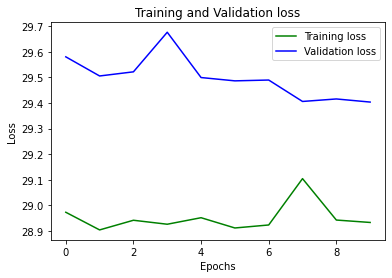

In [28]:
%matplotlib inline
NUM_EPOCHS=hyperparams['num_epochs']
plt.plot(range(0,len(train_losses)), train_losses, 'g', label='Training loss')
plt.plot(range(0,len(train_losses)), val_losses, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()